# Data Analysis

At this time of the project, we have a fully working POC of an application that process Streaming Data in real time and uses machine learning to do online predictions. The results of the predictions are currently being stored in a MySQL database. 

In particular, this application reads a stream of tweets related to Covid-19, pre-process them and uses state-of-the-art NLP models to do sentiment and topic prediction analysis. Finally, these results are post-processed and written into a relational database in AWS. 

In this dashboard, we analyize our results

In [1]:
########### Database Connection ##################

import pymysql


ENDPOINT = "database-kaka.c8wdpocz3thc.us-east-1.rds.amazonaws.com"
PASSWORD = "Bf2TiD4M4aOpbglEd9lM"
DBNAME = "databasekafka"
USR = "admin"
PORT = 3306
connection = pymysql.connect(host=ENDPOINT, user=USR, password=PASSWORD, port=PORT, db=DBNAME)

Now, let's read the data that we created with `pandas`:

In [2]:
import pandas as pd
query = 'SELECT * FROM covid_tweets'
result = pd.read_sql(query, connection)
connection.close() #close the connection
result.head()

,id,tweet,date_creation,sentiment_prediction,sentiment_score,topic_prediction,topic_score
0,84,RT @capeandcowell: China kills 2 million with ...,2021-01-24 16:43:24,NEGATIVE,1.0,China,0.0
1,85,RT @tylerblack32: THREAD: School closure and ...,2021-01-24 16:43:24,POSITIVE,1.0,mental health,1.0
2,86,RT @WalshFreedom: It just never gets said enou...,2021-01-24 16:43:24,NEGATIVE,1.0,vaccines,0.0
3,87,RT @DrEricDing: This is bad—Berlin has just pu...,2021-01-24 16:43:24,NEGATIVE,1.0,disease,0.0
4,88,RT @deenie7940: Nine Days In Covid-19 History:...,2021-01-24 16:43:24,NEGATIVE,1.0,politics,0.0


## Sentiment Analysis

We expect much more negative predictions than positive predictions:

In [3]:
result.value_counts('sentiment_prediction')

sentiment_prediction
NEGATIVE    15244
POSITIVE     3060
dtype: int64

And indeed there are. Out of the 18'000 tweets processed, only 3'000 have a positive sentiment. Let's check the word clouds for both batches of predictions.

In [4]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

def word_cloud_sentiment(sentiment):

    text = " ".join(tweet for tweet in result.query(f'sentiment_prediction=="{sentiment}"')["tweet"])

    stopwords = set(STOPWORDS)
    stopwords.update(["RT", "https", "t", "COVID", "coronavirus", "Covid-19", "pandemic", "co",
                     "s"])
    print(f"{sentiment} tweets: Word cloud \n")
    wordcloud = WordCloud(stopwords=stopwords, background_color="white",
                         width=2000, height= 1200).generate(text)
    plt.figure(figsize=(20,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [7]:
result.value_counts('topic_prediction')

topic_prediction
politics               4212
disease                4179
conspiracy             1982
vaccines               1725
death                  1720
mental health           692
public health           668
comedy                  665
globalization           547
commerce                458
education               450
sports events           358
natural environment     247
the economy             245
China                   156
dtype: int64

Here are the word clouds for each of the topics:

In [8]:
def create_word_cloud(topic):
    text = " ".join(tweet for tweet in result.query(f'topic_prediction=="{topic}"')["tweet"])

    stopwords = set(STOPWORDS)
    stopwords.update(["RT", "https", "t", "COVID", "coronavirus", "Covid-19", "pandemic", "co",
                 "s", "sound", "starting", "lot", "u"])
    wordcloud = WordCloud(stopwords=stopwords, background_color="white",
                     width=2000, height= 1200).generate(text)
    plt.figure(figsize=(20,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

# Sentiment and Topic Prediction

Let's try to analyze how sentiment and topic prediction are related. For example, which are the topics that were most mentioned in the positive tweets relative to the negative tweets? Are vaccines most tweeted in a positive or in a negative fashinon?

The following plots will help us to solve those questions. 

## Sentiments within topics

With the following table, we can analyze the sentiment within each topic. For example, what percentage of the vaccines tweets were positive? What percentage were negative? 

And so on for the different topics predicted. 

In [10]:
pivot_values = pd.crosstab(result['topic_prediction'], result['sentiment_prediction'],normalize='index') \
                 .round(2)
pivot_values['difference'] = pivot_values.eval('NEGATIVE-POSITIVE')
pivot_values.sort_values('difference', ascending = False)

sentiment_prediction,NEGATIVE,POSITIVE,difference
topic_prediction,,,
death,0.93,0.07,0.86
vaccines,0.89,0.11,0.78
conspiracy,0.88,0.12,0.76
mental health,0.87,0.13,0.74
China,0.86,0.14,0.72
the economy,0.85,0.15,0.70
public health,0.84,0.16,0.68
disease,0.83,0.17,0.66
politics,0.83,0.17,0.66


In the table to the left, for each combination of `topic_prediction` and `sentiment_prediction`, it appears the percentage of the combination in all the predictions for the given topic. That is, of all the tweets about vaccines, 89% were of a negative sentiment and 11% were with a positive sentiment. 

That is, most tweets about death had a negative sentiment. Whereas the balance evens out the most with globalization. 

In [11]:
pivot_values = pd.crosstab(result['topic_prediction'], result['sentiment_prediction'],normalize='columns') \
                 .round(2)
pivot_values['difference'] = pivot_values.eval('NEGATIVE-POSITIVE')
pivot_values.sort_values('difference', ascending = False)

sentiment_prediction,NEGATIVE,POSITIVE,difference
topic_prediction,,,
death,0.10,0.04,0.06
vaccines,0.10,0.06,0.04
conspiracy,0.11,0.08,0.03
mental health,0.04,0.03,0.01
China,0.01,0.01,0.00
politics,0.23,0.23,0.00
public health,0.04,0.04,0.00
the economy,0.01,0.01,0.00
disease,0.23,0.24,-0.01


## Topics across Sentiments

With the following table, we can analyze which topics were the most popular within each sentiment. For example, which was the most popular topic in the positive tweets? Which was for the negative tweets?

Whereas for negative tweets the death topic represents 10%, for the positive tweets it only represents 4%. Conversely, globalization tweets represent the 7% of the positive tweets; however, globalization tweets only represent 2% of the overall negative tweets. 

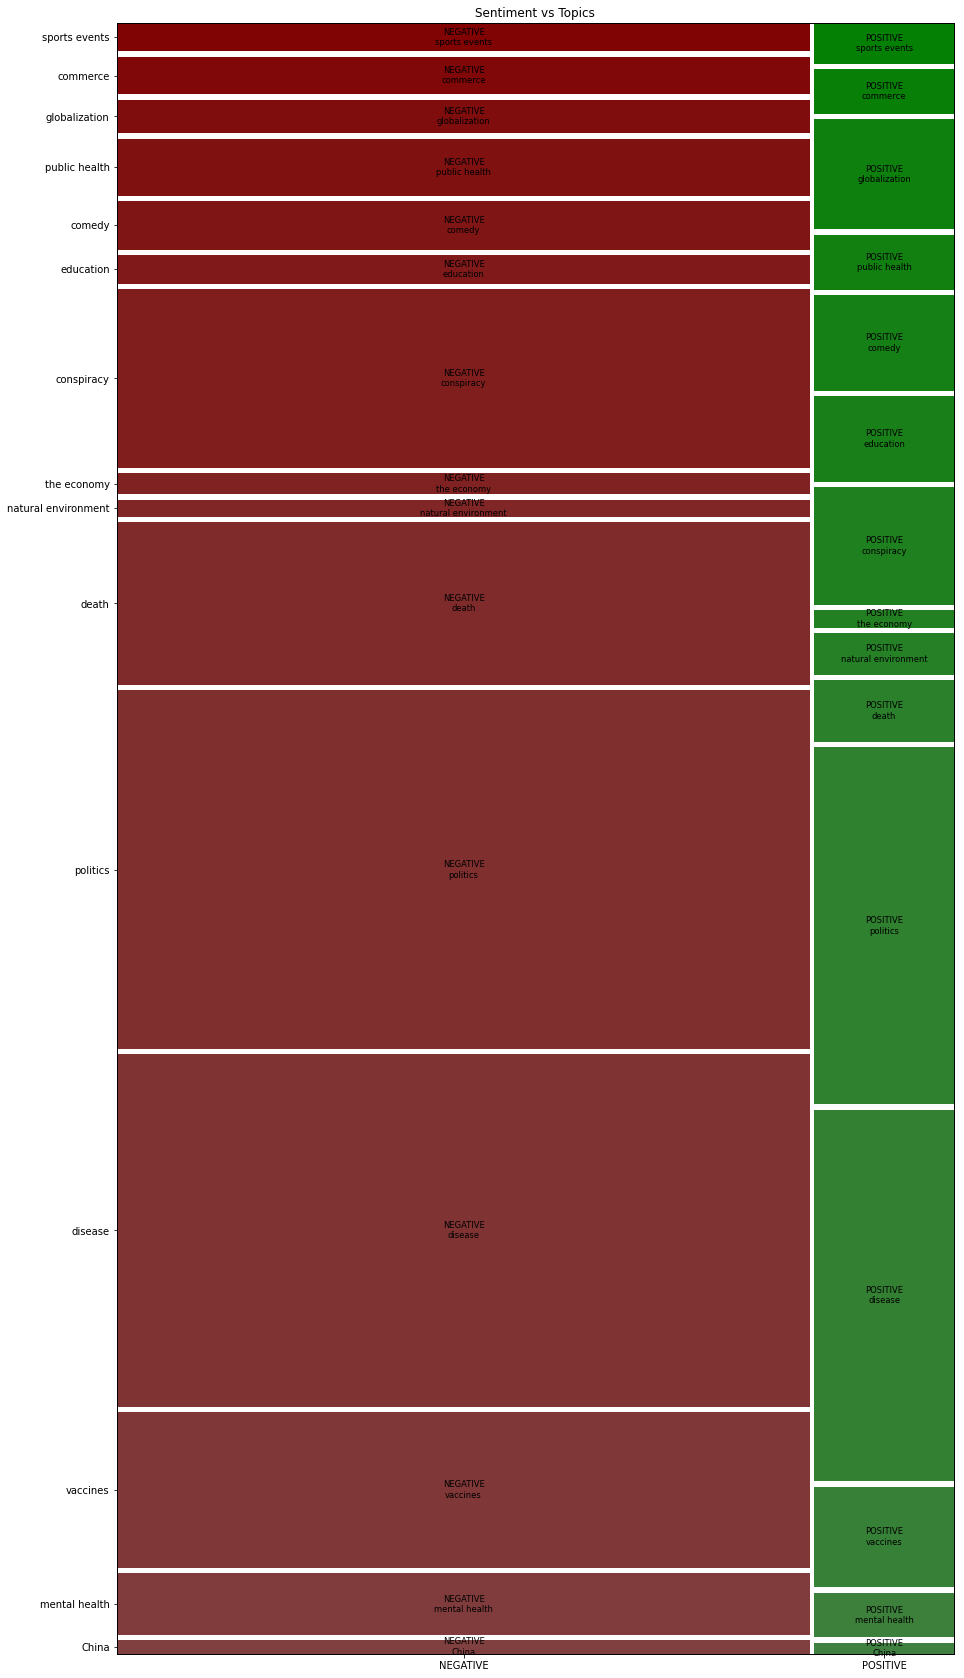

In [12]:
from statsmodels.graphics.mosaicplot import mosaic
import matplotlib as mpl
with mpl.rc_context():
    mpl.rc("figure", figsize=(15, 30))
    mosaic(result, ['sentiment_prediction', 'topic_prediction'], 
          title = "Sentiment vs Topics")

# Creating widgets out of the analysis

In [13]:
import ipywidgets as widgets

## Word Clouds: Different Topics

With the following widget, you can see the word clouds for the tweets that were predicted at each of the 14 different topics with the Zero Shot Learning models from Hugging face. 

In [14]:
widgets.interact(create_word_cloud, topic = result.value_counts('topic_prediction').index)

interactive(children=(Dropdown(description='topic', options=('politics', 'disease', 'conspiracy', 'vaccines', …

<function __main__.create_word_cloud(topic)>

## Word Clouds: Different Sentiments

With the following widget, you can see the word clouds for the tweets that the Zero Shot Learning model from Hugging Face predicted. 

In [15]:
widgets.interact(word_cloud_sentiment, sentiment=["NEGATIVE", "POSITIVE"])

interactive(children=(Dropdown(description='sentiment', options=('NEGATIVE', 'POSITIVE'), value='NEGATIVE'), O…

<function __main__.word_cloud_sentiment(sentiment)>